# 1.

_The probability of the evolutionary process can be calculated through_:
$$ P(Tree) = [{\prod_{i=1}^{E} P(dt_i) * P(Event | dt_i) }] + P(E_t > T)$$

_Where_:
$$ P(dt_i) = N * (\lambda{_{t_i}} + \mu{_{t_i}}) * e ^ {N * (-t_i) * (\lambda{_{t_i}} + \mu{_{t_i}})} $$
$$ P(Birth | dt_i) = {(\lambda{_{t_i}}) \over N * (\lambda{_{t_i}} + \mu{_{t_i}})}  $$
$$ P(Death | dt_i) = {(\mu{_{t_i}}) \over N * (\lambda{_{t_i}} + \mu{_{t_i}})}  $$

and $E_t$ is the time at which the last event occurs and $dt_i$ is $E_i - E_{i-1}$.

_Hence $P(Tree)$ can be simplified to_:
$$ P(Tree) = [{\prod_{i=1}^{E} e ^ {N * (-t_i) * (\lambda{_{t_i}} + \mu{_{t_i}})} * i_{rate} }] + P(E_t > T)$$

### We first start by defining 2 functions:
 -  wait_between_events(): calculates the probability of waiting a certain amount of time (df-di) between events given the current population number N, rates lamda and mniu. If with_evebt parameter is True, then we have a birth, if its False we have a death, else its just a waiting time.
 - get_lamb_t():  retrieves the lambda according to current number of population N, some initial lambda lamb_0 and some parameter B

In [344]:
import numpy as np

def wait_between_events(N, lamb, mniu, di, df, event=None):
    p = 1
    if event is not None:
        if event:
            p = lamb
        else:
            p = mniu
    return np.exp(-N*(lamb + mniu)*(df-di))*p

def get_lamb_t(N, lamb_0=0.8, B=-0.075):
    return max(lamb_0 - B*N,0)

### So then the probability of the current base tree can be computed as follows

In [40]:
events = [(5,True), (10,True), (20,None)]

tree_prob = 1
number_species = 1
mniu = 0.1

for i in range(len(events)):
    if i==0:
        di,df,event = 0,events[0][0],events[0][1]
    else:
        di,df,event = events[i-1][0], events[i][0], events[i][1]

    if event is None:
        tree_prob *= wait_between_events(number_species, get_lamb_t(number_species), mniu, di,df)
    else:
        tree_prob *= wait_between_events(number_species, get_lamb_t(number_species), mniu, di,df, event)
        number_species += 1 if event else -1

print(tree_prob)

3.8460527355226085e-22


# 2. 

### There are 6 cases we have to consider seperately for the inovation and extinction of the missing branch as seen in the following pictures.

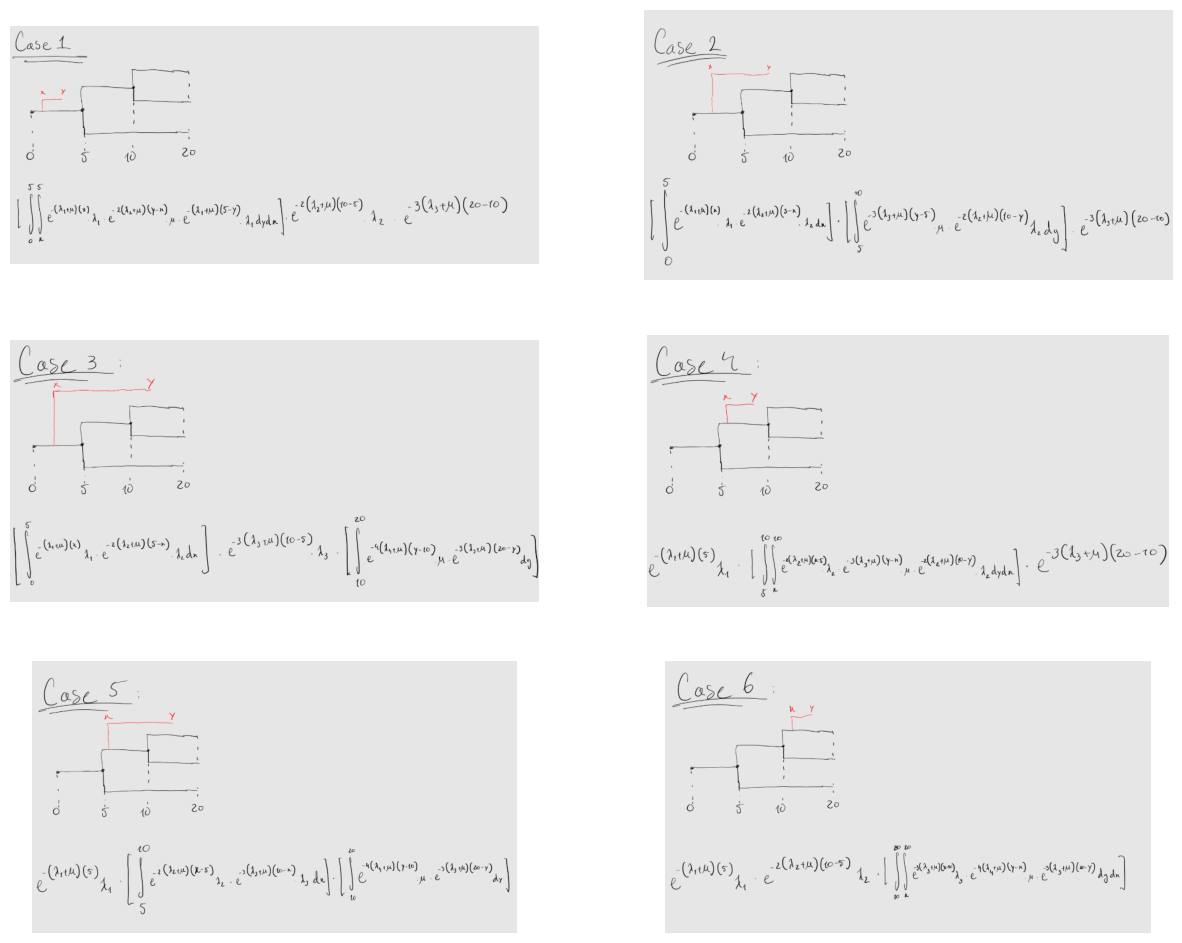

In [12]:
# load the 6 pictures in ./assets/ named case1.png, case2.png, ..., case6.png, and show them in  a 3 by 2 plot and make the figure size big
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(3, 2, figsize=(15, 12))
for i in range(6):
    img = mpimg.imread(f'./assets/case{i+1}.png')
    axs[i//2, i%2].imshow(img)
    axs[i//2, i%2].axis('off')
plt.show()


* Case 1: 
$$
\int_0^5 \int_s^5 \lambda_{1} e^{-(\lambda_{1} + \mu) s} \mu e^{-2(\lambda_{2} + \mu)(t-s)} \lambda_{1} e^{-(\lambda_{1} + \mu) (5 - t)}  dt ds  \cdot \lambda_{2} e^{-2(\lambda_{2} + \mu)(10-5)}   \cdot e^{-3(\lambda_{3} + \mu)(20-10)}
$$ 

* Case 2:
$$
\int_0^5 \lambda_{1} e^{-(\lambda_{1} + \mu) s} \lambda_{2} e^{-2(\lambda_{2} + \mu)(5-s)} ds \cdot \int_5^{10} \mu e^{-3(\lambda_{3} + \mu)(t - 5)} \lambda_{2} e^{-2(\lambda_{2} + \mu) (10 - t)} dt  \cdot e^{-3(\lambda_{3} + \mu)(20-10)}
$$

* Case 3:
$$
\int_0^5 \lambda_{1} e^{-(\lambda_{1} + \mu) s} \lambda_{2} e^{-2(\lambda_{2} + \mu)(5-s)} ds \cdot  \lambda_{3} e^{-3(\lambda_{3} + \mu)(10-5)} \cdot \int_{10}^{20} \mu e^{-4(\lambda_{4} + \mu)(t - 10)} e^{-3(\lambda_{3} + \mu) (20 - t)} dt
$$

* Case 4:
$$
\lambda_{1} e^{-(\lambda_{1} + \mu)5}  \cdot \int_5^{10} \int_s^{10} \lambda_{2} e^{-2(\lambda_{2} + \mu) (s - 5)} \mu e^{-3(\lambda_{3} + \mu)(t-s)} \lambda_{2} e^{-(\lambda_{2} + \mu) (10 - t)}  dt ds   \cdot e^{-3(\lambda_{3} + \mu)(20-10)}
$$ 

* Case 5:
$$
\lambda_{1} e^{-(\lambda_{1} + \mu)5}  \cdot \int_5^{10}  \lambda_{2} e^{-2(\lambda_{2} + \mu) (s - 5)} \lambda_{3} e^{-3(\lambda_{3} + \mu) (10 - s)}  ds   \cdot \int_{10}^{20}  \mu e^{-4(\lambda_{4} + \mu) (t - 10)} e^{-3(\lambda_{3} + \mu) (20 - t)} dt
$$

* Case 6:
$$
[\lambda_{1} * e^{-(\lambda_{1} + \mu) 5}][\lambda_{2} *e^{-2(\lambda_{2} + \mu)5}][\int_{10}^{20} \int_s^{20} \lambda_{3} *e^{-3(\lambda_{3} + \mu)(s - 10)} \mu * e^{-4(\lambda_{4} + \mu)(t-s)} e^{-3(\lambda_{3} + \mu)(20-t)}  dtds ]
$$

In [15]:
from  scipy.integrate import dblquad, quad
from functools import partial

integrand1 = lambda x,y: wait_between_events(1, get_lamb_t(1), mniu, 0, x, True) * wait_between_events(2, get_lamb_t(2), mniu, x, y, False) * wait_between_events(1, get_lamb_t(1), mniu, y, 5, True)
integrand21 = lambda x: wait_between_events(1, get_lamb_t(1), mniu, 0, x, True) * wait_between_events(2, get_lamb_t(2), mniu, x, 5, True)
integrand22 = lambda y: wait_between_events(3, get_lamb_t(3), mniu, 5, y, False) * wait_between_events(2, get_lamb_t(2), mniu, y, 10, True)
integrand31 = integrand21
integrand32 = lambda y: wait_between_events(4, get_lamb_t(4), mniu, 10, y, False) * wait_between_events(3, get_lamb_t(3), mniu, y, 20)
integrand4 = lambda x,y: wait_between_events(2, get_lamb_t(2), mniu, 5, x, True) * wait_between_events(3, get_lamb_t(3), mniu, x, y, False) * wait_between_events(2, get_lamb_t(2), mniu, y, 10, True)
integrand51 = lambda x: wait_between_events(2, get_lamb_t(2), mniu, 5, x, True) * wait_between_events(3, get_lamb_t(3), mniu, x, 10, True)
integrand52 = lambda y: wait_between_events(4, get_lamb_t(4), mniu, 10, y, False) * wait_between_events(3, get_lamb_t(3), mniu, y, 20)
integrand6 = lambda x,y: wait_between_events(3, get_lamb_t(3), mniu, 10, x, True) * wait_between_events(4, get_lamb_t(4), mniu, x, y, False) * wait_between_events(3, get_lamb_t(3), mniu, y, 20)

In [16]:
result1 = dblquad(integrand1, 0, 5, lambda x: x, lambda x: 5)[0] * wait_between_events(2, get_lamb_t(2), mniu, 5, 10, True) * wait_between_events(3, get_lamb_t(3), mniu, 10, 20)
result2 = quad(integrand21, 0, 5)[0] * quad(integrand22, 5, 10)[0] * wait_between_events(3, get_lamb_t(3), mniu, 10, 20)
result3 = quad(integrand31, 0, 5)[0] * wait_between_events(3, get_lamb_t(3), mniu, 5, 10, True) * quad(integrand32, 10, 20)[0]
result4 = wait_between_events(1, get_lamb_t(1), mniu, 0, 5, True) * dblquad(integrand4, 5, 10, lambda x: x, lambda x: 10)[0] * wait_between_events(3, get_lamb_t(3), mniu, 10, 20)
result5 = wait_between_events(1, get_lamb_t(1), mniu, 0, 5, True) * quad(integrand51, 5, 10)[0] * quad(integrand52, 10, 20)[0]
result6 = wait_between_events(1, get_lamb_t(1), mniu, 0, 5, True) * wait_between_events(2, get_lamb_t(2), mniu, 5, 10, True) * dblquad(integrand6, 10, 20, lambda x: x, lambda x: 20)[0]

### Having computed all integrals for each case approprietely, we can sum these probabilities and this should give as the result we are looking for.

In [25]:
result = result1 + result2 + result3 + result4 + result5 + result6
print(result)

2.9998187634072637e-17


# 3. 
### We design a function for each of the cases, then depending on the sampled inovation and extinction times we get and the correspondent number of species. We can normalize the term to scale the probabilities according to the provided sampling formula, where the extinction time is sampled from ther remaining time $T - T_{innovation}$

$$ f_m(x|\theta, x_{\text{obs}})   \approx  \frac{1}{T}*\frac{1}{T - T_{innovation}}*\frac{1}{Nt} $$

In [31]:
case1 = lambda x,y: integrand1(x,y) * wait_between_events(2, get_lamb_t(2), mniu, 5, 10, True) * wait_between_events(3, get_lamb_t(3), mniu, 10, 20)
case2 = lambda x,y: integrand21(x) * integrand22(y) * wait_between_events(3, get_lamb_t(3), mniu, 10, 20)
case3 = lambda x,y: integrand31(x) * wait_between_events(3, get_lamb_t(3), mniu, 5, 10, True) * integrand32(y)
case4 = lambda x,y: wait_between_events(1, get_lamb_t(1), mniu, 0, 5, True) * integrand4(x,y) * wait_between_events(3, get_lamb_t(3), mniu, 10, 20)
case5 = lambda x,y: wait_between_events(1, get_lamb_t(1), mniu, 0, 5, True) * integrand51(x) * integrand52(y)
case6 = lambda x,y: wait_between_events(1, get_lamb_t(1), mniu, 0, 5, True) * wait_between_events(2, get_lamb_t(2), mniu, 5, 10, True) * integrand6(x,y)

# This function returns the case according to x the inivation time and y the extinction time, and also return the population size at the  starting time
def get_case_prob_Nt(x,y):
    if x < 5 and y < 5:
        return case1(x,y), 1
    elif x < 5 and y < 10:
        return case2(x,y), 1
    elif x < 5 and y < 20:
        return case3(x,y), 1
    elif x < 10 and y < 10:
        return case4(x,y), 2
    elif x < 10 and y < 20:
        return case5(x,y), 2
    else:
        return case6(x,y), 3


In [45]:
probabilities = []
num_trials = 100000
events = [(5,True), (10,True), (20,None)]

T = 20
for _ in range(num_trials):
    inovation = np.random.uniform(0,T)
    extinction = np.random.uniform(inovation,T)
    case_prob, Nt = get_case_prob_Nt(inovation, extinction)
    normalization = (1/T) * (1/(T-inovation)) * (1/Nt)
    probabilities.append(case_prob / normalization)
    
mean = np.mean(probabilities)
std = np.std(probabilities)
print(mean, std)

1.1852343603210232e-21 2.5890736837805782e-21


# 4.

### The idea here is to build the following functions:
* compute_events_and_population(missing_branches): this function takes as argument the number of missing branches and computes samples inovation and extinction times, while also computing the normalization term. Having computed the times, it iterates through both lists algoritmically to assess the current number of species at any event time.

* simulate_tree_prob(num_missing_branches): this function uses the compute_events_and_population(), wait_between_events() and get_lamb() functions to compute the tree probability according to the sampled times and number of missing branches.

In [341]:
def compute_events_and_population_uniform(num_missing_branches, inno = [5,10], exti = [], N_0 = 1, T = 20):
    innovations = inno.copy()
    extinctions = exti.copy()
    normalization = 1
    
    for _ in range(num_missing_branches):
        innovation = np.random.uniform(0,T)
        extinction = np.random.uniform(innovation,T)
        innovations.append(innovation)
        extinctions.append(extinction)
        parents = len([i for i in innovations if i < innovation])-len([i for i in extinctions if i < innovation])+N_0
        normalization *= ((1/T) * (1/(T-innovation)) * (1/parents))
        
    innovations.sort()
    extinctions.sort()
    
    return normalization, innovations, extinctions


def simulate_tree_prob_uniform(num_missing_branches, inno = [5,10], exti = [], N_0 = 1, T = 20, mniu = 0.1):
    normalization, innovations, extinctions = compute_events_and_population_uniform(num_missing_branches, inno, exti, N_0, T)
    tree_prob = 1/normalization
    
    k,l = 0,0
    last_time = 0
    evolution = [N_0]
    
    while k < len(innovations) or l < len(extinctions):
        if l >= len(extinctions) or (k < len(innovations) and innovations[k] < extinctions[l]):
            tree_prob *= wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), mniu, last_time, innovations[k], True)
            last_time = innovations[k]
            k += 1
            evolution.append(evolution[-1]+1)
        elif k >= len(innovations) or (l < len(extinctions) and innovations[k] > extinctions[l]):
            tree_prob *= wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), mniu, last_time, extinctions[l], False)
            last_time = extinctions[l]
            l += 1
            evolution.append(evolution[-1]-1)
        else:
            tree_prob *= ((wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), mniu, last_time, innovations[k], True) + wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), mniu, last_time, extinctions[l], False))/2)
            last_time = innovations[k]
            k += 1
            l += 1
            evolution.append(evolution[-1])
            print('Entered rare state')
    
    tree_prob *= wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), mniu, last_time, T)
    return tree_prob, evolution

### Having the functions implemented, we can run num_trials for all number of missing branches from 0 to num_max_missing_branches. We can then scale the resulting probabilities, so that they sum up to 1, to further assess their difference. We can also represent them in a bar plot with a log scale on the y-axis to further ilustrate the difference.

Raw probability of 0 missing branches: 3.8460527355225586e-22
Raw probability of 1 missing branches: 1.0407502134214927e-21
Raw probability of 2 missing branches: 4.6093998843158445e-21
Raw probability of 3 missing branches: 9.960130406997215e-21
Raw probability of 4 missing branches: 9.361882953645686e-20
Raw probability of 5 missing branches: 1.1026574917500594e-19
Raw probability of 6 missing branches: 7.920146619141451e-20
Raw probability of 7 missing branches: 6.484216984003846e-20
Raw probability of 8 missing branches: 5.273299754735099e-21
Raw probability of 9 missing branches: 2.5568840506024653e-18
Raw probability of 10 missing branches: 2.7557012167937514e-19


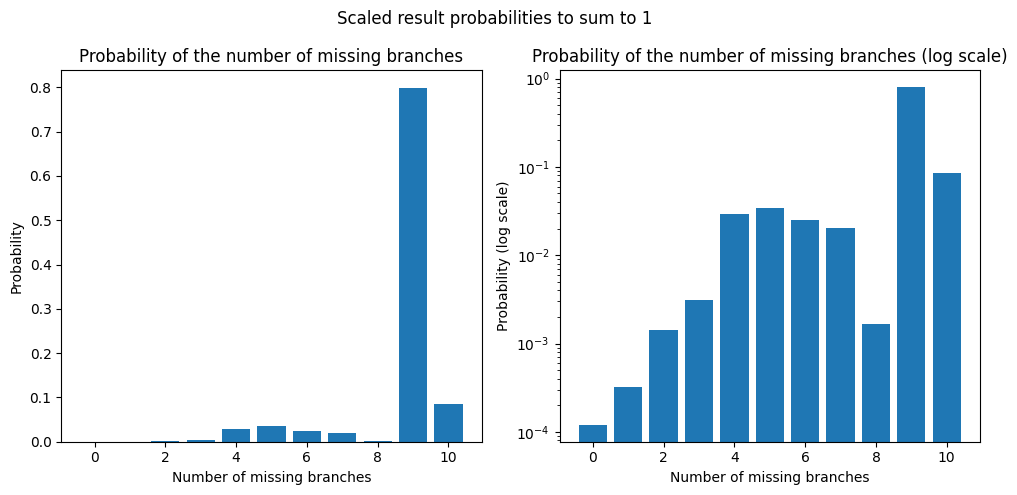

In [342]:
num_max_missing_branches = 10
num_trials = 1000
results_uniform = []

for i in range(num_max_missing_branches+1):
    acc = 0
    for _ in range(num_trials):
        acc += simulate_tree_prob_uniform(i)[0]
    results_uniform.append(acc/num_trials)
    
results_uniform = np.array(results_uniform)
scaled_results_uniform = results_uniform/np.sum(results_uniform)

for i in range(num_max_missing_branches+1):
    print(f"Raw probability of {i} missing branches: {results_uniform[i]}")

plt.figure(figsize=(10, 5))
plt.suptitle('Scaled result probabilities to sum to 1')

plt.subplot(1, 2, 1)
plt.bar(range(num_max_missing_branches+1), scaled_results_uniform)
plt.xlabel('Number of missing branches')
plt.ylabel('Probability')
plt.title('Probability of the number of missing branches')

plt.subplot(1, 2, 2)
plt.bar(range(num_max_missing_branches+1), scaled_results_uniform)
plt.xlabel('Number of missing branches')
plt.ylabel('Probability (log scale)')
plt.title('Probability of the number of missing branches (log scale)')
plt.yscale('log')

plt.tight_layout()
plt.show()

### We can see that the probabilities for the trees on 0 missing branches and 1 missing branches are very close to our previously computed values. Thus reinforcing that this method is valid.

# 5.

### Instead of sampling the times from a uniform distribution, we will now sample from an exponential distribution with a rate of 10 (any value can be chosen for rate). We have to accomodate for the fact that we will be sampling from a bounded exponential distribution, for each sampled value x we have to consider the factor 
$$ PDF(x)/(PDF(upper\_bound) - PDF(lower\_bound)) $$ 

In [323]:
from scipy.stats import expon

def sample_bounded_exponential(lower_bound, upper_bound, scale=10):
    sample = None
    while sample is None:
        samp = np.random.exponential(scale)
        if samp > lower_bound and samp < upper_bound:
            sample = samp
    return sample

def density_bounded_exponential(x, lower_bound, upper_bound, scale=10):
    return expon.pdf(x, scale=scale) / (expon.cdf(upper_bound, scale=scale) - expon.cdf(lower_bound, scale=scale))

def compute_events_and_population_exponential(num_missing_branches, inno=[5,10], exti=[], N_0=1, T=20, lower_bound=0, scale=10):
    innovations = inno.copy()
    extinctions = exti.copy()
    normalization = 1
    
    for _ in range(num_missing_branches):
        innovation = sample_bounded_exponential(lower_bound, T, scale)
        extinction = sample_bounded_exponential(innovation, T, scale)
        innovations.append(innovation)
        extinctions.append(extinction)
        n1 = density_bounded_exponential(innovation, 0, T, scale)
        n2 = density_bounded_exponential(extinction, innovation, T, scale)
        parents = len([i for i in innovations if i < innovation])-len([i for i in extinctions if i < innovation])+N_0
        normalization *= (n1*n2/parents)
         
    innovations.sort()
    extinctions.sort()

    return normalization, innovations, extinctions


def simulate_tree_prob_exponential(num_missing_branches, inno=[5,10], exti=[], N_0=1, T=20, mniu=0.1, scale=10):
    normalization, innovations, extinctions = compute_events_and_population_exponential(num_missing_branches, inno, exti, N_0, T, scale)
    tree_prob = 1/normalization
    
    k,l = 0,0
    last_time = 0
    evolution = [N_0]
    
    while k < len(innovations) or l < len(extinctions):
        if l >= len(extinctions) or (k < len(innovations) and innovations[k] < extinctions[l]):
            tree_prob *= wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), mniu, last_time, innovations[k], True)
            last_time = innovations[k]
            k += 1
            evolution.append(evolution[-1]+1)
        elif k >= len(innovations) or (l < len(extinctions) and innovations[k] > extinctions[l]):
            tree_prob *= wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), mniu, last_time, extinctions[l], False)
            last_time = extinctions[l]
            l += 1
            evolution.append(evolution[-1]-1)
        else:
            tree_prob *= ((wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), mniu, last_time, innovations[k], True) + wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), mniu, last_time, extinctions[l], False))/2)
            last_time = innovations[k]
            k += 1
            l += 1
            evolution.append(evolution[-1])
            print('Entered rare state')
    
    tree_prob *= wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), mniu, last_time, T)
    return tree_prob, evolution

Raw probability of 0 missing branches: 3.8460527355225586e-22
Raw probability of 1 missing branches: 2.8558583343655145e-21
Raw probability of 2 missing branches: 1.9741122911154867e-20
Raw probability of 3 missing branches: 1.196893066705913e-19
Raw probability of 4 missing branches: 9.982820811156957e-19
Raw probability of 5 missing branches: 1.1510141972769484e-17
Raw probability of 6 missing branches: 7.060302394073315e-17
Raw probability of 7 missing branches: 3.027450342481e-16
Raw probability of 8 missing branches: 1.0508464311469666e-15
Raw probability of 9 missing branches: 4.9561161840893437e-14
Raw probability of 10 missing branches: 7.15761154998883e-14


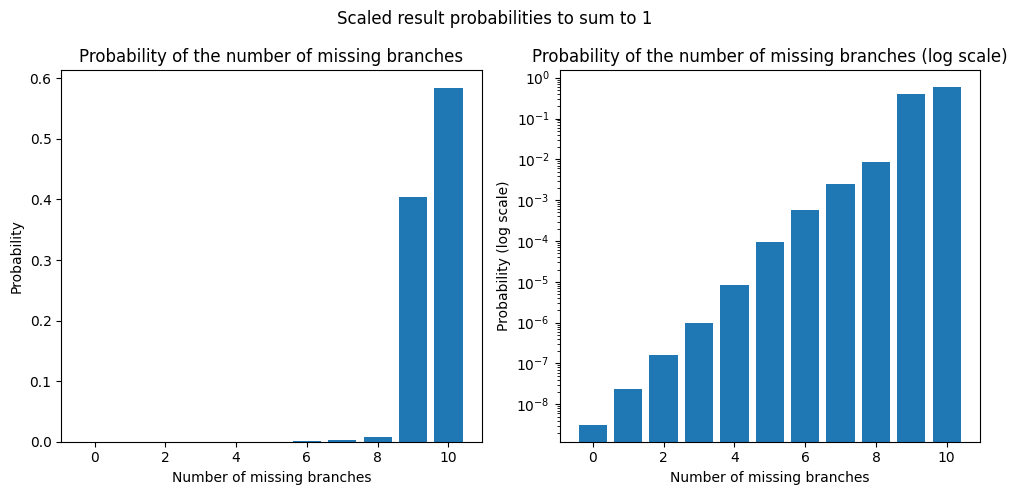

In [336]:
num_max_missing_branches = 10
num_trials = 1000
results_exponential = []

for i in range(num_max_missing_branches+1):
    acc = 0
    for _ in range(num_trials):
        acc += simulate_tree_prob_exponential(i)[0]
    results_exponential.append(acc/num_trials)
    
results_exponential = np.array(results_exponential)
scaled_results_exponential = results_exponential/np.sum(results_exponential)

for i in range(num_max_missing_branches+1):
    print(f"Raw probability of {i} missing branches: {results_exponential[i]}")

plt.figure(figsize=(10, 5))
plt.suptitle('Scaled result probabilities to sum to 1')

plt.subplot(1, 2, 1)
plt.bar(range(num_max_missing_branches+1), scaled_results_exponential)
plt.xlabel('Number of missing branches')
plt.ylabel('Probability')
plt.title('Probability of the number of missing branches')

plt.subplot(1, 2, 2)
plt.bar(range(num_max_missing_branches+1), scaled_results_exponential)
plt.xlabel('Number of missing branches')
plt.ylabel('Probability (log scale)')
plt.title('Probability of the number of missing branches (log scale)')
plt.yscale('log')

plt.tight_layout()
plt.show()

In [343]:
from scipy.stats import ks_2samp

ks_statistic, p_value = ks_2samp(results_uniform, results_exponential)
print(f"KS statistic: {ks_statistic}")
print(f"P-value: {p_value}")


KS statistic: 0.5454545454545454
P-value: 0.0746606334841629


### From the above code we can see that we have a p-value of 0.07 between the two results we got, which tells us the null hypothesis doesn't verify between distributions of values. In other words, they are likely to represent the same distribution, hence proving that both are valid and somewhat equivelant sampling methods.

# 6.

### Similarly to the dynamic birth rate, we can implement a function for the death rate and put it inside our functions. Everything else should remain the same. So lets redifine the whole code.

In [350]:
def wait_between_events(N, lamb, mniu, di, df, event=None):
    p = 1
    if event is not None:
        if event:
            p = lamb
        else:
            p = mniu
    return np.exp(-N*(lamb + mniu)*(df-di))*p

def get_lamb_t(N, lamb_0=0.8, B=-0.075):
    return max(lamb_0 - B*N,0)

def get_mniu_t(N, mniu_0=2, B=-0.075):
    return max(mniu_0 - B*N, 0)

### Experiment 3 with dynamic mniu

In [351]:
from  scipy.integrate import dblquad, quad
from functools import partial

integrand1 = lambda x,y: wait_between_events(1, get_lamb_t(1), get_mniu_t(1), 0, x, True) * wait_between_events(2, get_lamb_t(2), get_mniu_t(2), x, y, False) * wait_between_events(1, get_lamb_t(1), get_mniu_t(1), y, 5, True)
integrand21 = lambda x: wait_between_events(1, get_lamb_t(1), get_mniu_t(1), 0, x, True) * wait_between_events(2, get_lamb_t(2), get_mniu_t(2), x, 5, True)
integrand22 = lambda y: wait_between_events(3, get_lamb_t(3), get_mniu_t(3), 5, y, False) * wait_between_events(2, get_lamb_t(2), get_mniu_t(2), y, 10, True)
integrand31 = integrand21
integrand32 = lambda y: wait_between_events(4, get_lamb_t(4), get_mniu_t(4), 10, y, False) * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), y, 20)
integrand4 = lambda x,y: wait_between_events(2, get_lamb_t(2), get_mniu_t(2), 5, x, True) * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), x, y, False) * wait_between_events(2, get_lamb_t(2), get_mniu_t(2), y, 10, True)
integrand51 = lambda x: wait_between_events(2, get_lamb_t(2), get_mniu_t(2), 5, x, True) * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), x, 10, True)
integrand52 = lambda y: wait_between_events(4, get_lamb_t(4), get_mniu_t(4), 10, y, False) * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), y, 20)
integrand6 = lambda x,y: wait_between_events(3, get_lamb_t(3), get_mniu_t(3), 10, x, True) * wait_between_events(4, get_lamb_t(4), get_mniu_t(4), x, y, False) * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), y, 20)

result1 = dblquad(integrand1, 0, 5, lambda x: x, lambda x: 5)[0] * wait_between_events(2, get_lamb_t(2), get_mniu_t(2), 5, 10, True) * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), 10, 20)
result2 = quad(integrand21, 0, 5)[0] * quad(integrand22, 5, 10)[0] * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), 10, 20)
result3 = quad(integrand31, 0, 5)[0] * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), 5, 10, True) * quad(integrand32, 10, 20)[0]
result4 = wait_between_events(1, get_lamb_t(1), get_mniu_t(1), 0, 5, True) * dblquad(integrand4, 5, 10, lambda x: x, lambda x: 10)[0] * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), 10, 20)
result5 = wait_between_events(1, get_lamb_t(1), get_mniu_t(1), 0, 5, True) * quad(integrand51, 5, 10)[0] * quad(integrand52, 10, 20)[0]
result6 = wait_between_events(1, get_lamb_t(1), get_mniu_t(1), 0, 5, True) * wait_between_events(2, get_lamb_t(2), get_mniu_t(2), 5, 10, True) * dblquad(integrand6, 10, 20, lambda x: x, lambda x: 20)[0]

case1 = lambda x,y: integrand1(x,y) * wait_between_events(2, get_lamb_t(2), get_mniu_t(2), 5, 10, True) * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), 10, 20)
case2 = lambda x,y: integrand21(x) * integrand22(y) * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), 10, 20)
case3 = lambda x,y: integrand31(x) * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), 5, 10, True) * integrand32(y)
case4 = lambda x,y: wait_between_events(1, get_lamb_t(1), get_mniu_t(1), 0, 5, True) * integrand4(x,y) * wait_between_events(3, get_lamb_t(3), get_mniu_t(3), 10, 20)
case5 = lambda x,y: wait_between_events(1, get_lamb_t(1), get_mniu_t(1), 0, 5, True) * integrand51(x) * integrand52(y)
case6 = lambda x,y: wait_between_events(1, get_lamb_t(1), get_mniu_t(1), 0, 5, True) * wait_between_events(2, get_lamb_t(2), get_mniu_t(2), 5, 10, True) * integrand6(x,y)

# This function returns the case according to x the inivation time and y the extinction time, and also return the population size at the  starting time
def get_case_prob_Nt(x,y):
    if x < 5 and y < 5:
        return case1(x,y), 1
    elif x < 5 and y < 10:
        return case2(x,y), 1
    elif x < 5 and y < 20:
        return case3(x,y), 1
    elif x < 10 and y < 10:
        return case4(x,y), 2
    elif x < 10 and y < 20:
        return case5(x,y), 2
    else:
        return case6(x,y), 3
    
probabilities = []
num_trials = 100000
events = [(5,True), (10,True), (20,None)]

T = 20
for _ in range(num_trials):
    inovation = np.random.uniform(0,T)
    extinction = np.random.uniform(inovation,T)
    case_prob, Nt = get_case_prob_Nt(inovation, extinction)
    normalization = (1/T) * (1/(T-inovation)) * (1/Nt)
    probabilities.append(case_prob / normalization)
    
mean = np.mean(probabilities)
std = np.std(probabilities)
print(mean, std)

1.356303449668687e-61 5.0124265118241756e-61


### mniu_0 was deliberately set to 2 so that the extinction rate is very high compared to innovation rate. We can see that the probability of have 1 missing branch is lower, which is congruent with the definition of the dynamic mniu

### Experiment 4

Raw probability of 0 missing branches: 5.093861419898042e-63
Raw probability of 1 missing branches: 1.4426044230194545e-61
Raw probability of 2 missing branches: 4.017009944406916e-60
Raw probability of 3 missing branches: 8.190967857361451e-60
Raw probability of 4 missing branches: 7.479425195201616e-59
Raw probability of 5 missing branches: 5.0883934343127285e-59
Raw probability of 6 missing branches: 3.0089020744788457e-60
Raw probability of 7 missing branches: 3.4951190122871477e-59
Raw probability of 8 missing branches: 1.1432426920510763e-58
Raw probability of 9 missing branches: 8.256192626812844e-62
Raw probability of 10 missing branches: 3.516613175603202e-61


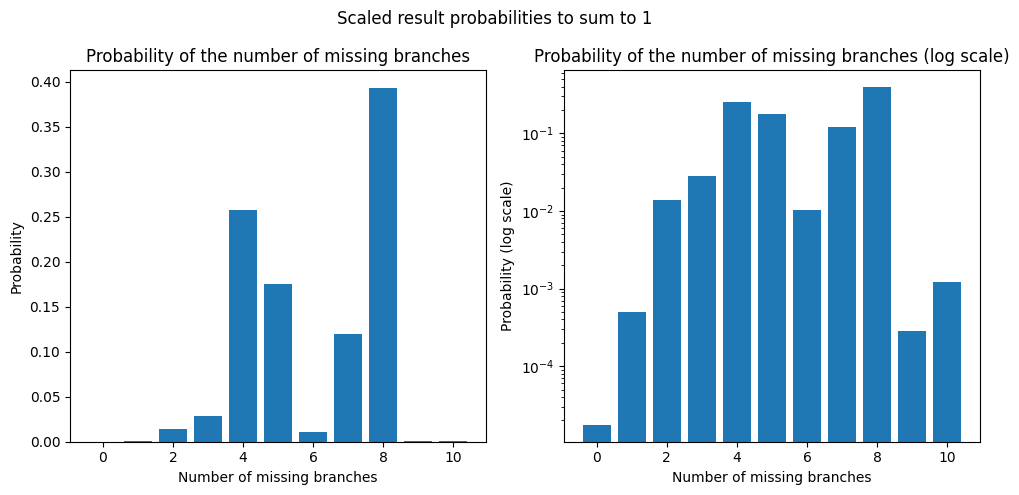

In [353]:
def simulate_tree_prob_uniform_dynamic_mniu(num_missing_branches, inno = [5,10], exti = [], N_0 = 1, T = 20):
    normalization, innovations, extinctions = compute_events_and_population_uniform(num_missing_branches, inno, exti, N_0, T)
    tree_prob = 1/normalization
    
    k,l = 0,0
    last_time = 0
    evolution = [N_0]
    
    while k < len(innovations) or l < len(extinctions):
        if l >= len(extinctions) or (k < len(innovations) and innovations[k] < extinctions[l]):
            tree_prob *= wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), get_mniu_t(evolution[-1]), last_time, innovations[k], True)
            last_time = innovations[k]
            k += 1
            evolution.append(evolution[-1]+1)
        elif k >= len(innovations) or (l < len(extinctions) and innovations[k] > extinctions[l]):
            tree_prob *= wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), get_mniu_t(evolution[-1]), last_time, extinctions[l], False)
            last_time = extinctions[l]
            l += 1
            evolution.append(evolution[-1]-1)
        else:
            tree_prob *= ((wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), get_mniu_t(evolution[-1]), last_time, innovations[k], True) + wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), get_mniu_t(evolution[-1]), last_time, extinctions[l], False))/2)
            last_time = innovations[k]
            k += 1
            l += 1
            evolution.append(evolution[-1])
            print('Entered rare state')
    
    tree_prob *= wait_between_events(evolution[-1], get_lamb_t(evolution[-1]), get_mniu_t(evolution[-1]), last_time, T)
    return tree_prob, evolution


num_max_missing_branches = 10
num_trials = 1000
results_uniform = []

for i in range(num_max_missing_branches+1):
    acc = 0
    for _ in range(num_trials):
        acc += simulate_tree_prob_uniform_dynamic_mniu(i)[0]
    results_uniform.append(acc/num_trials)
    
results_uniform = np.array(results_uniform)
scaled_results_uniform = results_uniform/np.sum(results_uniform)

for i in range(num_max_missing_branches+1):
    print(f"Raw probability of {i} missing branches: {results_uniform[i]}")

plt.figure(figsize=(10, 5))
plt.suptitle('Scaled result probabilities to sum to 1')

plt.subplot(1, 2, 1)
plt.bar(range(num_max_missing_branches+1), scaled_results_uniform)
plt.xlabel('Number of missing branches')
plt.ylabel('Probability')
plt.title('Probability of the number of missing branches')

plt.subplot(1, 2, 2)
plt.bar(range(num_max_missing_branches+1), scaled_results_uniform)
plt.xlabel('Number of missing branches')
plt.ylabel('Probability (log scale)')
plt.title('Probability of the number of missing branches (log scale)')
plt.yscale('log')

plt.tight_layout()
plt.show()

### Because of the high death rate, we can see that lower values of missing branches tend to have highest probability of occuring, which again is congruent with the definition of dynamic mniu.